### Impervious layer processing

In [58]:
from osgeo import gdal, gdalconst
import numpy as np
from osgeo import gdal, ogr
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, gdal_array
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rioxarray as rxr
import shapely
from shapely.geometry import mapping


In [34]:
path = "/home/vrobledodelgado/hpchome/SERVIR/CREST_parameters/IM/"
tif_file = "Ghana_nodata.tif"


In [35]:
# Abrir el archivo .tif
dataset = gdal.Open(path+tif_file)

In [37]:
# Read raster data as numpy array
image = dataset.ReadAsArray()
print(type(image))

<class 'numpy.ndarray'>


In [39]:
import numpy as np
from scipy.ndimage import distance_transform_edt, map_coordinates

# Mask of where values are 255
mask = (image == 255)
mask


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [51]:
# Compute the Euclidean distance to the nearest non-255 cell
distance, nearest_index = distance_transform_edt(mask, return_indices=True)

# Get values from the nearest non-255 cells
arr_interpolated = image.copy()
arr_interpolated[mask] = image[tuple(nearest_index[:, mask])]

print(arr_interpolated)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


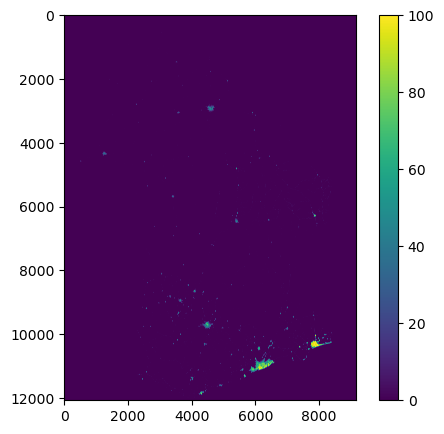

In [53]:
arr_interpolated[arr_interpolated == 200] = 0  #non-Hbase

plt.figure(figsize=(6, 5))
im = plt.imshow(arr_interpolated)
plt.colorbar(im)

In [54]:
output_tif_file = "/home/vrobledodelgado/hpchome/SERVIR/CREST_parameters/IM/interpolated_data.tif"
driver = gdal.GetDriverByName("GTiff")
output_dataset = driver.Create(output_tif_file, arr_interpolated.shape[1], arr_interpolated.shape[0], 1, gdal_array.NumericTypeCodeToGDALTypeCode(arr_interpolated.dtype))

# Step 2: Write the interpolated data data to the new TIFF file
output_dataset.GetRasterBand(1).WriteArray(arr_interpolated)

# Step 3: Define spatial reference system (optional)
# You may need to adjust the spatial reference system based on your data
output_dataset.SetProjection(dataset.GetProjection())
output_dataset.SetGeoTransform(dataset.GetGeoTransform())

# Step 4: Close the dataset
output_dataset = None

### Clipping the layer using shapefile

In [55]:
def clip_raster(pathraster, shapefile):
    raster = rxr.open_rasterio(pathraster,
                           masked=True).squeeze()
    raster_clipped = raster.rio.clip(shapefile.geometry.apply(mapping))
    raster_clipped = raster_clipped.astype('float32')  # Set data type to float32
    array = raster_clipped.values
    array = np.where(np.isnan(array), -9999, array)  #conver nan values to -9999
    raster_output = raster_clipped.copy()
    raster_output.values = array
    raster_output.rio.write_nodata(int(-9999), inplace=True)  # Set NoData value to -9999
    raster_output.rio.write_crs("EPSG:4326", inplace=True)  # Set CRS to EPSG:4326

    return raster_output

In [59]:
ghana_ef5_shape = gpd.read_file('../GhanaEF5_90m/gis/L3_basins_ghana/Ghana_SR.shp')

IM_clipped = clip_raster(output_tif_file,ghana_ef5_shape)
IM_clipped.rio.to_raster("/home/vrobledodelgado/hpchome/SERVIR/CREST_parameters/IM/IM_final.tif")

In [ ]:
IM_clipped.plot(figsize = (6,6), cmap='plasma')